<a href="https://colab.research.google.com/github/Prompt-Sopa/CODERHOUSE-NLP-DL/blob/main/TP_Coder_Alsop_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabajo Final - CODERHOUSE

- Alumno: Agustin Alsop

##Actividad 2

- Considerando lo visto dentro de las clases de redes neuronales seleccionar un dataset de trabajo (puede ser nuevo o de los preparados para learning estilo MNIST).

- Cargar el dataset usando la función adecuada.

- Hacer una análisis exploratorio e identificar al menos tres insights sobre el mismo.

- Entrenar una red neuronal sencilla al menos dos capas (puede ser convolucional o recurrente).

- Plantear conclusiones.

##Extra

Como se opto desarrollar mas esta actividad se agrega lo siguiente

Para trabajo final si se opta por Deep Learning debe adicionarse alguna de las siguientes tareas:

- Adicionar al menos dos capas a la red para mejorar su rendimiento.

- Comparar los resultados contra el modelo sencillo. Dimensionar mejoras.

##Resolución

Para la realización de este trabajo se utilizó el set de datos de cifar10, la idea es entrenar una red neuronal que pueda diferenciar entre las distintas clases que se encuentran en el data set

## Importación de librerias

In [ ]:
%matplotlib inline
import matplotlib as mpl
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GaussianNoise, GaussianDropout, LayerNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.regularizers import L2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error
from sklearn.datasets import make_moons


mpl.rcParams['figure.figsize'] = [12.0, 8.0]
print(mpl.rcParams['figure.figsize'])

[12.0, 8.0]


## Carga de Datos

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Forma de y_train: (50000, 10)
Forma de y_test: (10000, 10)
100 primeros elementos del conjunto de entrenamiento


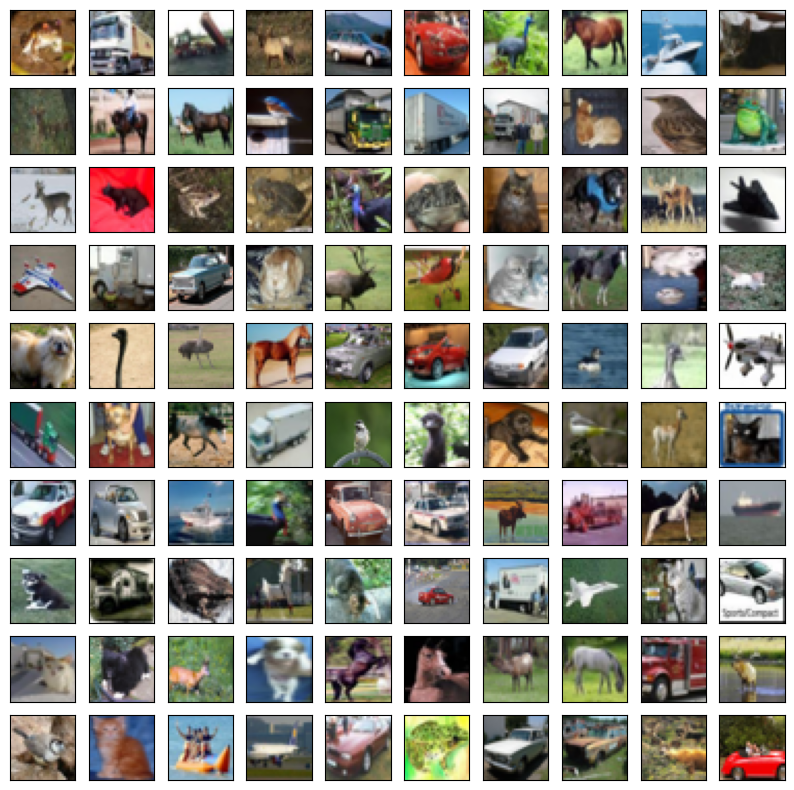

In [ ]:
# Cargar datos
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalización
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# One-hot encoding de las etiquetas
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Verificar dimensiones
print("Forma de y_train:", y_train.shape)
print("Forma de y_test:", y_test.shape)

# Mostrar los primeros 100 elementos del dataset
print("100 primeros elementos del conjunto de entrenamiento")
f = plt.figure(figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax = f.add_subplot(10, 10, i + j*10 + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(x_train[i + j*10])
plt.show()

Observamos como el data set en total contiene 60mil imagenes de 32x32 pixeles, se puede encontrar mas informacion de la base de datos en [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html).

De las 60mil imagenes se utilizaron 50 mil para entrenamiento y 10 mil para prueba

## Análisis exploratorio

Visualizamos y diferenciamos las clases

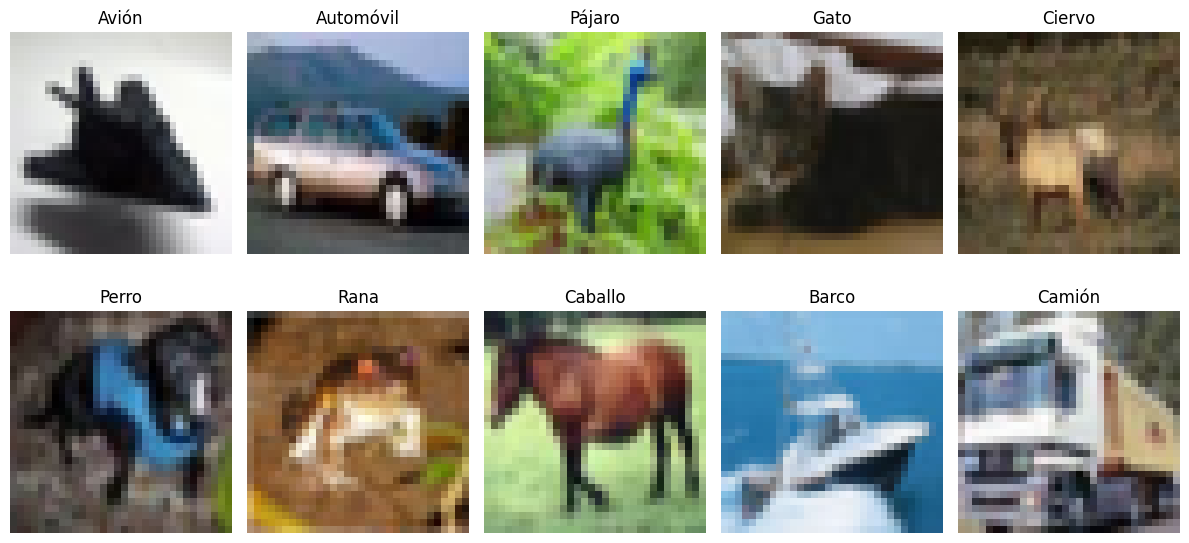

In [ ]:
# Convertir de one-hot a valores enteros si es necesario
if y_train.ndim > 1 and y_train.shape[1] == 10:
    y_train_2 = np.argmax(y_train, axis=1)

# Etiquetas de CIFAR-10
class_names = ["Avión", "Automóvil", "Pájaro", "Gato", "Ciervo",
               "Perro", "Rana", "Caballo", "Barco", "Camión"]

# Seleccionar una imagen por clase
unique_classes = np.unique(y_train_2)
images_per_class = {}

for img, label in zip(x_train, y_train_2.flatten()):
    if label not in images_per_class:
        images_per_class[label] = img
    if len(images_per_class) == 10:  # Tenemos todas las clases
        break

# Mostrar las imágenes
plt.figure(figsize=(12, 6))
for i, class_id in enumerate(unique_classes):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images_per_class[class_id])
    plt.title(class_names[class_id])
    plt.axis("off")

plt.tight_layout()
plt.show()

Podemos observar 10 clases en la base de datos compuestas por:
- Avión
- Automóvil
- Pájaro
- Gato
- Ciervo
- Perro
- Rana
- Caballo
- Barco
- Camión

De esta manera se puede ver la diferencias y complejidades de las imagenes, es un buen caso para estudiar como una red neuronal puede aprender para predecir de estas imagenes.

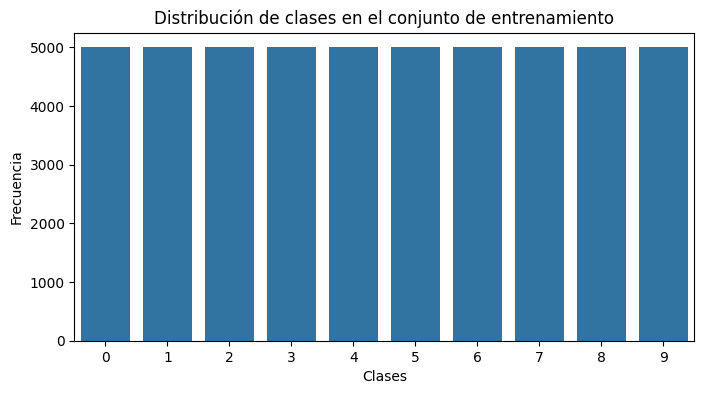

In [ ]:
# Convertir de one-hot a valores enteros
if y_train.ndim > 1 and y_train.shape[1] == 10:
    y_train_2 = np.argmax(y_train, axis=1)

# Contar frecuencia de clases
unique, counts = np.unique(y_train_2, return_counts=True)

# Graficar distribución de clases
plt.figure(figsize=(8,4))
sn.barplot(x=unique, y=counts)
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xticks(range(10))
plt.show()


Se observa como el data set de entrenamiento esta totalmente balanceado por clase, teniendo 5 mil imagenes de cada clase. Esto es bueno ya que el modelo no tenderá a sesgar por alguna clase con mayor cantidad de datos.

Media de los píxeles por canal (R, G, B): [0.4914009  0.48215896 0.4465308 ]
Desviación estándar de los píxeles por canal (R, G, B): [0.24703279 0.24348423 0.26158753]


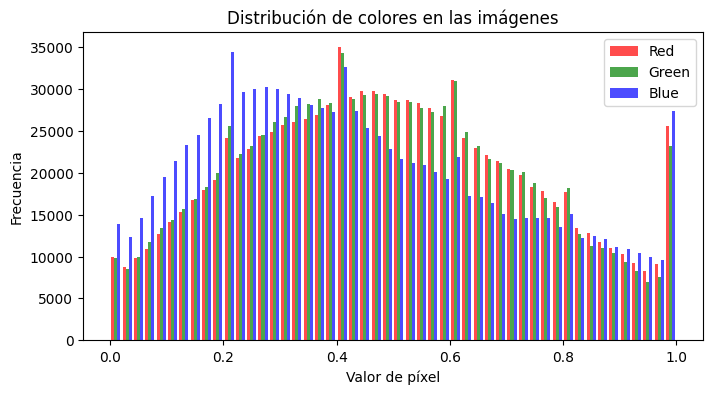

In [ ]:
# Media y desviación estándar de los valores de los píxeles (por canal)
mean_pixel = np.mean(x_train, axis=(0,1,2))
std_pixel = np.std(x_train, axis=(0,1,2))
print("Media de los píxeles por canal (R, G, B):", mean_pixel)
print("Desviación estándar de los píxeles por canal (R, G, B):", std_pixel)

# Histograma de valores RGB
plt.figure(figsize=(8,4))
plt.hist(x_train[:1000].reshape(-1, 3), bins=50, color=['r','g','b'], alpha=0.7, label=['Red', 'Green', 'Blue'])
plt.xlabel("Valor de píxel")
plt.ylabel("Frecuencia")
plt.title("Distribución de colores en las imágenes")
plt.legend()
plt.show()


A modo de información tambien podemos observar que la media de las componentes RGB de las imagenes es similar tanto para Red, Green y Blue

## Entrenamiento de Modelo

### Test 1: Modelo Simple
- Capa convulcional: 1
- Capa densa: 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.3932 - loss: 1.7265 - val_accuracy: 0.5384 - val_loss: 1.3238
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5654 - loss: 1.2638 - val_accuracy: 0.5697 - val_loss: 1.2311
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6012 - loss: 1.1465 - val_accuracy: 0.5771 - val_loss: 1.2040
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6297 - loss: 1.0695 - val_accuracy: 0.6060 - val_loss: 1.1266
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6463 - loss: 1.0280 - val_accuracy: 0.6102 - val_loss: 1.1274
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6642 - loss: 0.9795 - val_accuracy: 0.6182 - val_loss: 1.1002
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6820 - loss: 0.9331 - val_accuracy: 0.6419 - val_loss: 1.0465
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6908 - loss: 0.9054 - val_accuracy:

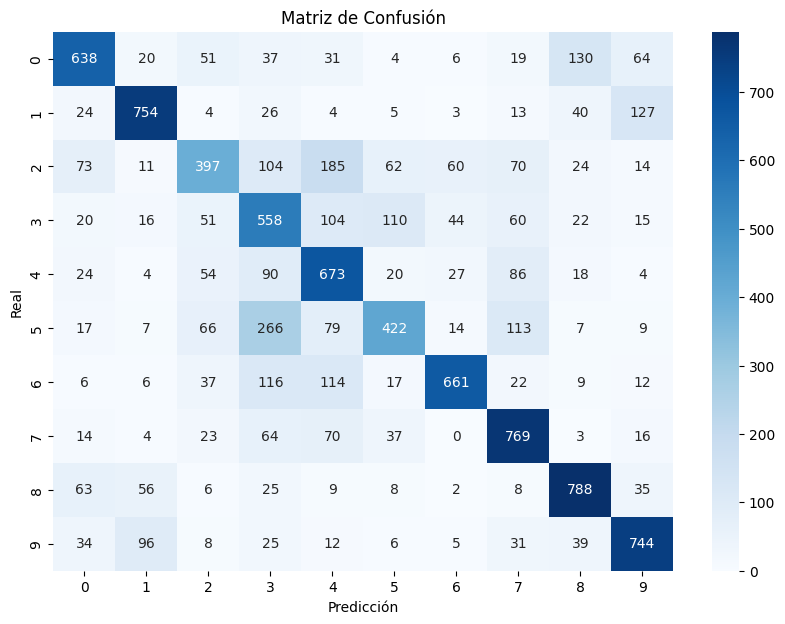

              precision    recall  f1-score   support

           0       0.70      0.64      0.67      1000
           1       0.77      0.75      0.76      1000
           2       0.57      0.40      0.47      1000
           3       0.43      0.56      0.48      1000
           4       0.53      0.67      0.59      1000
           5       0.61      0.42      0.50      1000
           6       0.80      0.66      0.73      1000
           7       0.65      0.77      0.70      1000
           8       0.73      0.79      0.76      1000
           9       0.72      0.74      0.73      1000

    accuracy                           0.64     10000
   macro avg       0.65      0.64      0.64     10000
weighted avg       0.65      0.64      0.64     10000



In [ ]:
model = Sequential([
    # Segunda capa convolucional con 32 filtros
    Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(32,32,3)),

    MaxPooling2D((2,2)),

    # Convertir los mapas de características en un vector
    Flatten(),

    Dense(10, activation="softmax")  # 10 clases de CIFAR-10
])

# Compilar modelo
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Entrenar modelo
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

# Evaluar modelo
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Precisión en test: {test_acc:.4f}")

# Predicciones
y_pred = model.predict(x_test)

# Convertir las predicciones y las etiquetas de one-hot a clases
y_pred = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Mostrar la matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred)

# Crear un gráfico de la matriz de confusión
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(map(str, range(10))), yticklabels=list(map(str, range(10))))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test_labels, y_pred))

Podemos observar que, con una red neuronal de dos capas, se obtiene un puntaje de accuracy del 74% en el conjunto de entrenamiento y del 64% en el conjunto de prueba. Aunque podemos afirmar que más del 50% de las predicciones fueron correctas, no podemos considerar que el modelo sea lo suficientemente bueno como para producir descripciones de manera confiable. Además, aunque el puntaje en el entrenamiento fue superior al del test, la diferencia no es lo suficientemente significativa como para concluir que hay overfitting fuerte.

En cuanto a las clases, la clase "Perro" obtuvo el menor puntaje de precisión, siendo la más difícil de predecir por nuestro modelo. Por otro lado, la clase "Pájaro" fue la más precisa, con un 81% de aciertos.

### Test 2: Modelo Mediano
- Capa convulcional: 2
- Capa densa: 2

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(32,32,3)),
    Conv2D(64, (3,3), activation="relu", padding="same"),

    MaxPooling2D(pool_size=(2,2)),
    Flatten(),

    Dense(128, activation="relu"),
    Dense(10, activation="softmax")  # 10 clases de CIFAR-10
])

# Compilar modelo
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Entrenar modelo
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

# Evaluar modelo
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Precisión en test: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.4441 - loss: 1.5586 - val_accuracy: 0.6403 - val_loss: 1.0342
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6751 - loss: 0.9381 - val_accuracy: 0.6570 - val_loss: 0.9759
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7307 - loss: 0.7717 - val_accuracy: 0.6873 - val_loss: 0.9008
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7804 - loss: 0.6292 - val_accuracy: 0.6968 - val_loss: 0.8980
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8246 - loss: 0.5030 - val_accuracy: 0.6971 - val_loss: 0.9337
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8744 - loss: 0.3718 - val_accuracy: 0.6939 - val_loss: 1.0316
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9139 - loss: 0.2597 - val_accuracy: 0.6866 - val_loss: 1.1470
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9389 - loss: 0.1863 - val_accuracy: 0

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


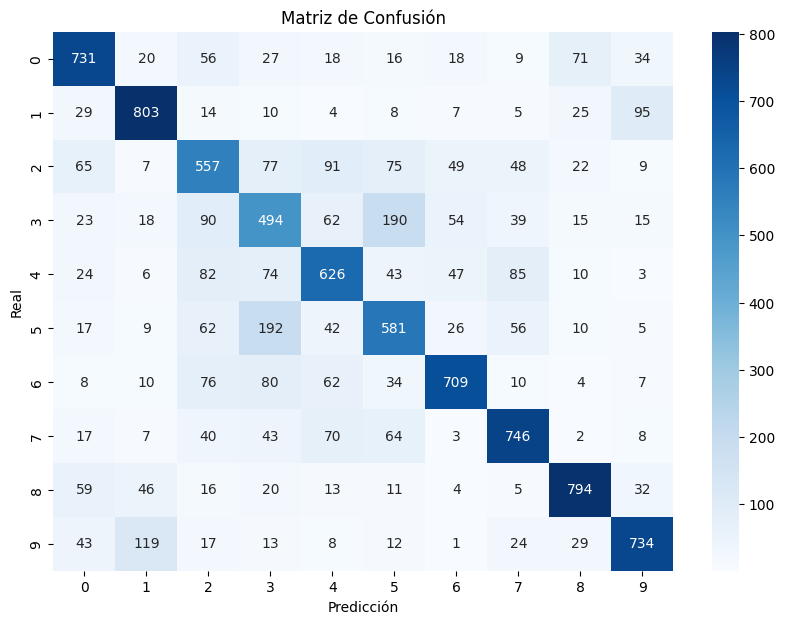

              precision    recall  f1-score   support

           0       0.72      0.73      0.73      1000
           1       0.77      0.80      0.79      1000
           2       0.55      0.56      0.55      1000
           3       0.48      0.49      0.49      1000
           4       0.63      0.63      0.63      1000
           5       0.56      0.58      0.57      1000
           6       0.77      0.71      0.74      1000
           7       0.73      0.75      0.74      1000
           8       0.81      0.79      0.80      1000
           9       0.78      0.73      0.76      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



In [ ]:
# Predicciones
y_pred = model.predict(x_test)

# Convertir las predicciones y las etiquetas de one-hot a clases
y_pred = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Mostrar la matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred)

# Crear un gráfico de la matriz de confusión
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(map(str, range(10))), yticklabels=list(map(str, range(10))))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test_labels, y_pred))

Podemos observar que, con una red neuronal de cuatro capas, se obtiene un puntaje de accuracy del 97% en el conjunto de entrenamiento y del 68% en el conjunto de prueba. Aunque más del 50% de las predicciones fueron correctas, no podemos considerar que el modelo sea lo suficientemente bueno como para producir descripciones de manera confiable. En este caso, el modelo mejoró un 20% en las métricas de entrenamiento, pero solo un 3% en el conjunto de prueba, lo que indica la presencia de mas overfitting. Esto sugiere que agregar capas no tuvo un impacto significativo en la capacidad del modelo para generalizar bien.

En cuanto a las clases, la clase "Gato" obtuvo el menor puntaje de precisión, siendo la más difícil de predecir por nuestro modelo. Por otro lado, la clase "Barco" fue la más precisa, con un 80% de aciertos.

### Test 3: Modelo Complejo
- Capa convulcional: 4
- Capa densa: 4

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(32,32,3)),
    Conv2D(64, (3,3), activation="relu", padding="same"),
    Conv2D(128, (3,3), activation="relu", padding="same"),
    Conv2D(256, (3,3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(10, activation="softmax")
])

# Compilar modelo
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Entrenar modelo
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

# Evaluar modelo
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Precisión en test: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.3267 - loss: 1.8121 - val_accuracy: 0.5712 - val_loss: 1.1881
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step - accuracy: 0.6037 - loss: 1.1065 - val_accuracy: 0.6740 - val_loss: 0.9253
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.7112 - loss: 0.8232 - val_accuracy: 0.6965 - val_loss: 0.8834
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.7743 - loss: 0.6550 - val_accuracy: 0.7160 - val_loss: 0.8317
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.8281 - loss: 0.4959 - val_accuracy: 0.7242 - val_loss: 0.8401
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.8714 - loss: 0.3623 - val_accuracy: 0.7218 - val_loss: 0.9306
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9157 - loss: 0.2443 - val_accuracy: 0.7028 - val_loss: 1.0709
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.9402 - loss: 0.1775 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


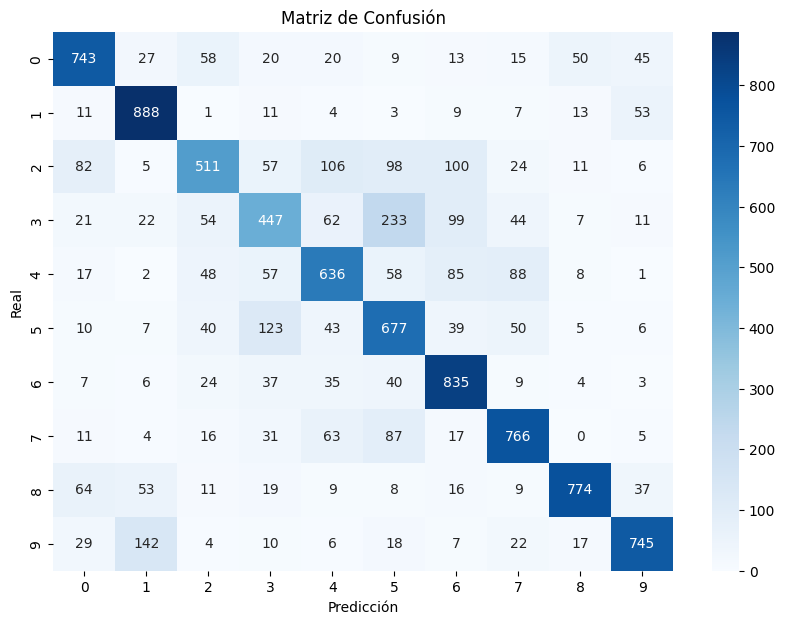

              precision    recall  f1-score   support

           0       0.75      0.74      0.74      1000
           1       0.77      0.89      0.82      1000
           2       0.67      0.51      0.58      1000
           3       0.55      0.45      0.49      1000
           4       0.65      0.64      0.64      1000
           5       0.55      0.68      0.61      1000
           6       0.68      0.83      0.75      1000
           7       0.74      0.77      0.75      1000
           8       0.87      0.77      0.82      1000
           9       0.82      0.74      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



In [ ]:
# Predicciones
y_pred = model.predict(x_test)

# Convertir las predicciones y las etiquetas de one-hot a clases
y_pred = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
# Mostrar la matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred)

# Crear un gráfico de la matriz de confusión
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(map(str, range(10))), yticklabels=list(map(str, range(10))))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test_labels, y_pred))

Podemos observar que, con una red neuronal de ocho capas, se obtiene un puntaje de accuracy del 96% en el conjunto de entrenamiento y del 70% en el conjunto de prueba. En este caso, obtuvimos el mejor rendimiento en el conjunto de prueba en comparación con los modelos anteriores.

En cuanto a las clases, la clase "Gato" obtuvo el menor puntaje de precisión, siendo la más difícil de predecir para nuestro modelo. Por otro lado, la clase "Barco" fue la más precisa, con un 87% de aciertos.

## Conclusiones

Podemos concluir que predecir el contenido de las fotos utilizando un modelo de redes neuronales es una tarea factible. Sin embargo, al analizar los resultados obtenidos con modelos más complejos, observamos que, aunque el rendimiento en el conjunto de entrenamiento mejora considerablemente al agregar más capas, este avance no se refleja de manera significativa en el conjunto de prueba. Esto sugiere que el modelo está aprendiendo detalles específicos del conjunto de entrenamiento, pero no logra generalizar bien a nuevos datos.

Este comportamiento es característico de un fenómeno conocido como overfitting, donde el modelo se ajusta demasiado a los datos de entrenamiento, perdiendo su capacidad para predecir correctamente sobre datos no vistos anteriormente. A pesar de lograr un alto rendimiento en el entrenamiento, la capacidad del modelo para generalizar a datos de prueba sigue siendo limitada.

En resumen, aunque los modelos más complejos pueden ofrecer un mejor ajuste en los datos de entrenamiento, la mejora en la precisión de las predicciones sobre datos nuevos no es proporcional, lo que resalta la necesidad de técnicas adicionales para prevenir el sobreajuste, como la regularización.